# Лабораторная работа 3.1 Анализ и визуализация временного ряда бизнес-показателей


**Цель работы.** Освоить ключевые методы анализа временных рядов на языке Python для решения практических бизнес-задач, таких как прогнозирование, выявление трендов и сезонности в экономических показателях.

## Введение. Почему временные ряды важны для бизнеса?

Временные ряды — это наборы данных, где каждая точка привязана к определенному моменту времени. Для бизнес-информатики это один из самых ценных активов, позволяющий:

- **Прогнозировать спрос.** Оптимизировать запасы и логистику.
- **Анализировать финансовые рынки.** Предсказывать цены акций и курсы валют.
- **Оценивать эффективность маркетинга.** Отслеживать влияние рекламных кампаний на продажи во времени.
- **Планировать ресурсы.** Прогнозировать нагрузку на серверы или количество обращений в колл-центр.

В этой работе мы научимся извлекать из временных данных ценные инсайты, строить и оценивать прогнозные модели.

### Основные характеристики временных рядов

- **Тренд (Trend).** Долгосрочное направление движения ряда (рост, падение, стагнация).
- **Сезонность (Seasonality).** Периодические, повторяющиеся колебания (например, рост продаж перед Новым годом).
- **Циклы (Cycles).** Долгосрочные волнообразные колебания, не связанные с фиксированным периодом, как у сезонности (например, экономические циклы).
- **Шум (Noise/Residual).** Случайные, непрогнозируемые колебания.
- **Стационарность.** Свойство ряда, при котором его статистические характеристики (среднее, дисперсия) не меняются со временем. Большинство моделей требуют, чтобы ряд был стационарным.

## Часть 1. Подготовка к анализу

Перед началом работы установим и импортируем все необходимые библиотеки.

In [1]:
# Установка библиотек (если требуется)
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn -q

# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Настройки для визуализаций
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### Работа с датами и временем в Pandas

Правильная работа с временными метками — основа анализа временных рядов. Pandas предоставляет мощный инструментарий для этого.

**Задание 1. Создание DataFrame и преобразование в формат даты**

Создайте DataFrame на основе предоставленных данных о продажах. Преобразуйте столбец `'Дата'` в специальный формат `datetime` с помощью `pd.to_datetime()` и выведите типы данных DataFrame с помощью `.info()`.

In [6]:
data = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
        'Продажи': [1000, 1200, 1300, 1100, 1400]}

# Ваш код здесь
# 1. Создайте DataFrame 'df' из словаря 'data'
df = pd.DataFrame(data)

# 2. Преобразуйте столбец 'Дата'
df['Дата'] = pd.to_datetime(df['Дата'])

# 3. Выведите информацию о DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Дата     5 non-null      datetime64[ns]
 1   Продажи  5 non-null      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 212.0 bytes


**Задание 2. Установка временного индекса**

Для удобной работы с временными рядами столбец с датами часто устанавливают в качестве индекса DataFrame. Используйте метод `.set_index()` для установки столбца `'Дата'` в качестве индекса.

In [7]:
# Ваш код здесь
# Установите 'Дата' в качестве индекса для df
df = df.set_index('Дата')
print(df)

            Продажи
Дата               
2023-01-01     1000
2023-02-01     1200
2023-03-01     1300
2023-04-01     1100
2023-05-01     1400


**Задание 3. Фильтрация данных по дате**

Используя временной индекс, выберите данные о продажах за период с марта по апрель 2023 года включительно.

In [8]:
# Ваш код здесь
selected_data = df['2023-03':'2023-04']
print(selected_data)

            Продажи
Дата               
2023-03-01     1300
2023-04-01     1100


### Обработка пропущенных значений

Реальные бизнес-данные часто содержат пропуски. Их корректная обработка — критически важный шаг.

**Задание 4. Обнаружение пропущенных значений**

Создайте новый DataFrame `df_missing` с пропущенным значением. Используйте `.isnull().sum()` для подсчета количества пропусков в каждом столбце.

In [19]:
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

# Ваш код здесь
# Посчитайте пропущенные значения
sum_missing = df_missing.isnull().sum()
print(sum_missing)

Продажи    1
dtype: int64


**Задание 5. Заполнение пропусков средним значением**

Заполните пропущенное значение в столбце `'Продажи'` средним значением этого же столбца. Это более robustный подход, чем заполнение нулем. Не забудьте переприсвоить результат.

In [20]:
# Ваш код здесь
# 1. Рассчитайте среднее по столбцу 'Продажи'
mean_sales = df_missing['Продажи'].mean()

# 2. Заполните пропуски с помощью .fillna()
df_missing['Продажи'] = df_missing['Продажи'].fillna(mean_sales)
print(df_missing)

            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1200.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


**Задание 6. Заполнение пропусков методом интерполяции**

Интерполяция заполняет пропуски, вычисляя промежуточные значения между двумя известными точками. Это часто дает более реалистичный результат. Примените метод `.interpolate()` к `df_missing`.

In [24]:
# Ваш код здесь
data_missing = {'Дата': ['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01'],
                  'Продажи': [1000, None, 1300, 1100, 1400]}
df_missing = pd.DataFrame(data_missing)
df_missing['Дата'] = pd.to_datetime(df_missing['Дата'])
df_missing.set_index('Дата', inplace=True)

df_missing['Продажи'] = df_missing['Продажи'].interpolate()
print(df_missing)

            Продажи
Дата               
2023-01-01   1000.0
2023-02-01   1150.0
2023-03-01   1300.0
2023-04-01   1100.0
2023-05-01   1400.0


## Часть 2. Исследовательский анализ временных рядов (EDA)

На этом этапе мы будем использовать реальный набор данных о ежемесячном производстве бензина в США. Наша цель — визуализировать данные и выявить их основные компоненты.

**Задание 7. Загрузка и подготовка данных**

Загрузите данные по ссылке. Убедитесь, что столбец с датой преобразован в `datetime` и установлен в качестве индекса. Выведите первые 5 строк.

In [28]:
# Ваш код здесь
gas_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_gasoline_production.csv"

# Загрузите данные, используя parse_dates=['date'] и index_col='date'
df_gasoline = pd.read_csv(
    gas_url,
    parse_dates=['date'],
    index_col=['date']
)
# 2. Вывод первых 5 строк для проверки
print("Первые 5 строк DataFrame с временным индексом:")
print(df_gasoline.head())

# 3. Проверка типа индекса (убедимся, что это DatetimeIndex)
print("\nТип индекса:")
print(type(df_gasoline.index))
print("\nИнформация о DataFrame:")
print(df_gasoline.info())

Первые 5 строк DataFrame с временным индексом:
            value
date             
1991-02-03  6.621
1991-02-10  6.433
1991-02-17  6.582
1991-02-24  7.224
1991-03-03  6.875

Тип индекса:
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>

Информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1355 entries, 1991-02-03 to 2017-01-15
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   1355 non-null   float64
dtypes: float64(1)
memory usage: 21.2 KB
None


**Задание 8. Визуализация временного ряда**

Постройте линейный график для столбца `'value'`, чтобы визуально оценить данные. Добавьте заголовок и подписи осей.

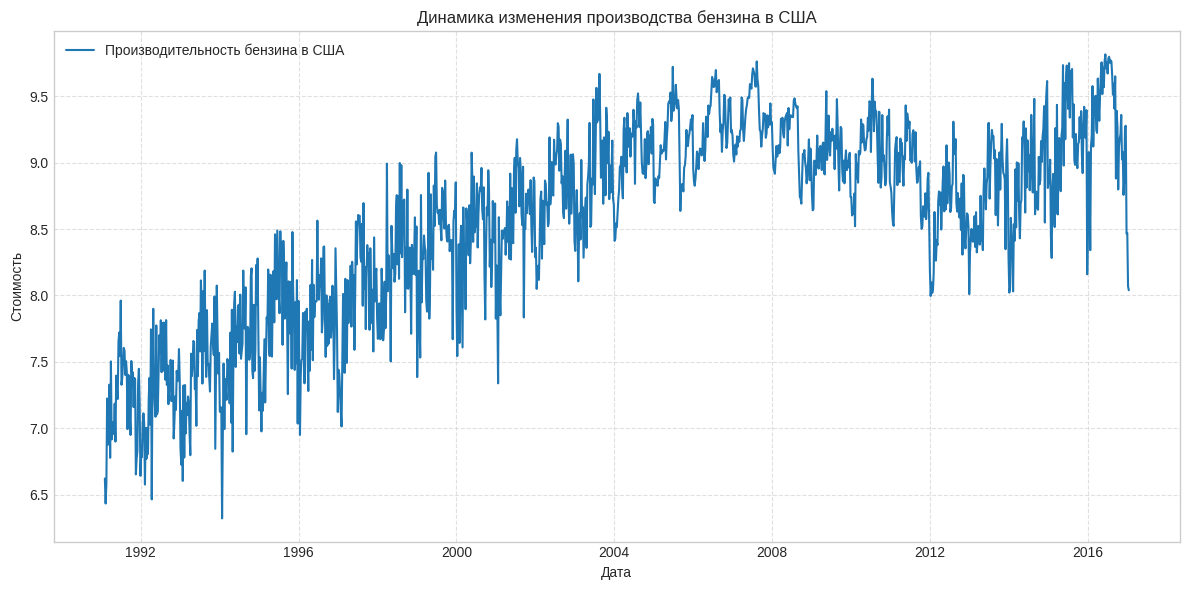

In [37]:
# Ваш код здесь
# 1. Построение графика
plt.figure(figsize=(12, 6)) # Устанавливаем размер графика для лучшей читаемости
plt.plot(df_gasoline.index, df_gasoline['value'], label='Производительность бензина в США')

# 2. Добавление заголовка и подписей осей
plt.title('Динамика изменения производства бензина в США')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.legend() # Отобразить легенду

# 3. Дополнительные настройки для красоты и читаемости
plt.grid(True, linestyle='--', alpha=0.6) # Добавляем сетку
plt.tight_layout() # Автоматически корректирует расположение элементов

# 4. Отображение графика
plt.show()

**Задание 9. Ресэмплинг для агрегации данных**

Исходные данные имеют еженедельную частоту, что делает график 'шумным'. Преобразуйте ряд в ежемесячный (`'M'`), агрегируя значения с помощью среднего (`.mean()`). Сохраните результат в `gas_monthly` и постройте график.

/tmp/ipython-input-3836427408.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gas_monthly = df_gasoline.resample('M').mean()


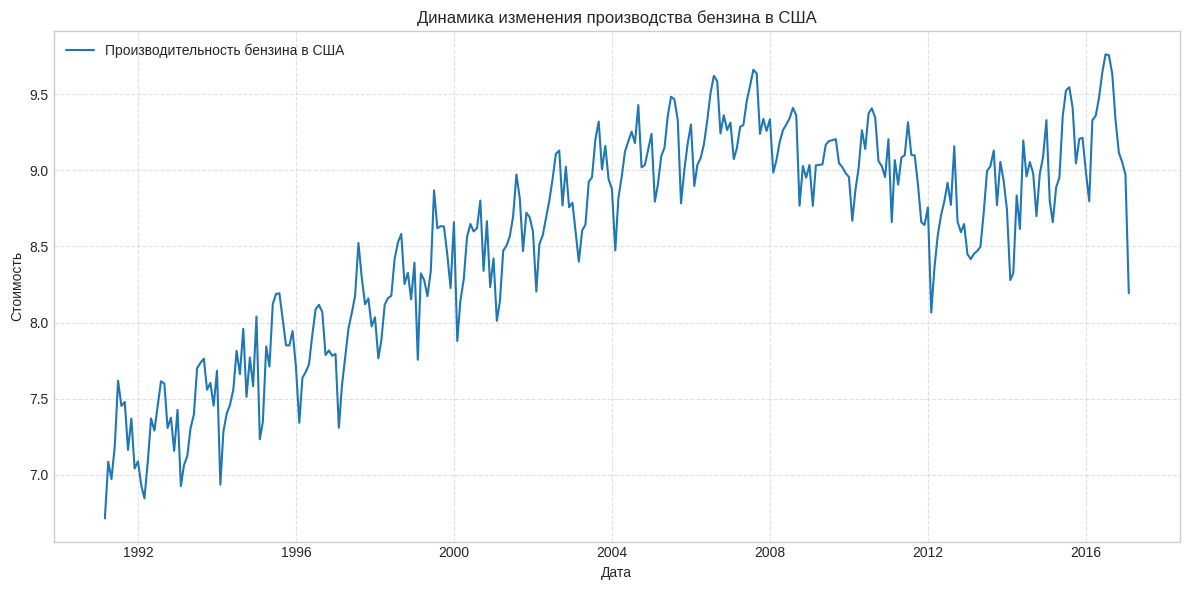

In [38]:
# Ваш код здесь
# 1. Выполните ресэмплинг
gas_monthly = df_gasoline.resample('M').mean()

# 2. Постройте график для gas_monthly['value']
# 1. Построение графика
plt.figure(figsize=(12, 6)) # Устанавливаем размер графика для лучшей читаемости
plt.plot(gas_monthly.index, gas_monthly['value'], label='Производительность бензина в США')

# 2. Добавление заголовка и подписей осей
plt.title('Динамика изменения производства бензина в США')
plt.xlabel('Дата')
plt.ylabel('Стоимость')
plt.legend() # Отобразить легенду

# 3. Дополнительные настройки для красоты и читаемости
plt.grid(True, linestyle='--', alpha=0.6) # Добавляем сетку
plt.tight_layout() # Автоматически корректирует расположение элементов

# 4. Отображение графика
plt.show()

**Задание 10. Сглаживание с помощью скользящего среднего**

Чтобы лучше увидеть долгосрочный тренд, примените скользящее среднее. Создайте новый столбец `'rolling_mean_12'` в `gas_monthly`, рассчитав среднее за 12 месяцев с помощью `.rolling(window=12).mean()`. Постройте на одном графике исходный ряд и сглаженный.

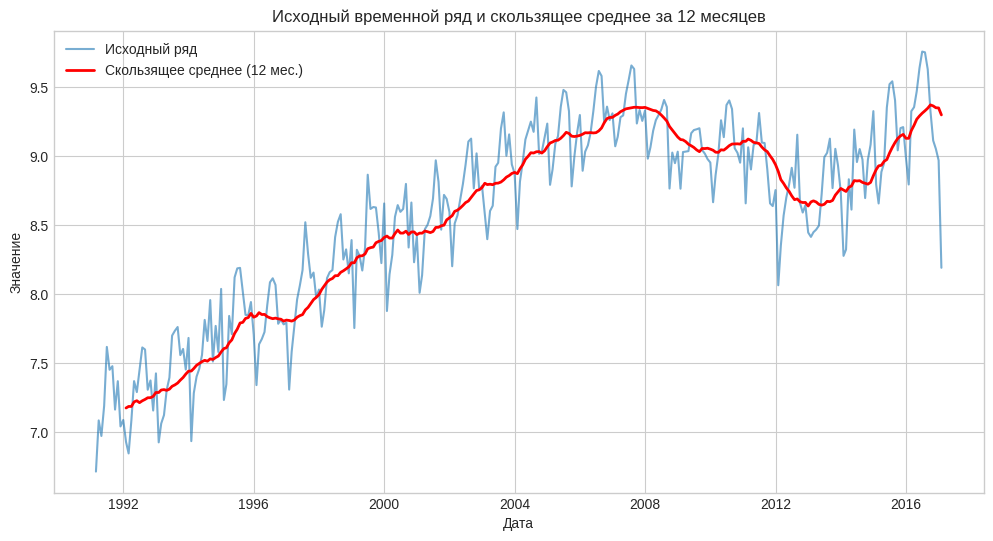

               value  rolling_mean_12
date                                 
2016-09-30  9.331500         9.373650
2016-10-31  9.115200         9.366146
2016-11-30  9.055000         9.352996
2016-12-31  8.971500         9.351475
2017-01-31  8.192667         9.301147


In [49]:
# Ваш код здесь
# 1. Рассчитайте скользящее среднее
# Создание нового столбца 'rolling_mean_12'
gas_monthly['rolling_mean_12'] = gas_monthly['value'].rolling(window=12).mean()

# 2. Постройте оба графика
plt.figure(figsize=(12, 6))

# Построение исходного ряда
plt.plot(gas_monthly.index, gas_monthly['value'], label='Исходный ряд', alpha=0.6)

# Построение сглаженного ряда
plt.plot(gas_monthly.index, gas_monthly['rolling_mean_12'], label='Скользящее среднее (12 мес.)', color='red', linewidth=2)

plt.title('Исходный временной ряд и скользящее среднее за 12 месяцев')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

# Вывод последних строк DataFrame, чтобы увидеть новый столбец
print(gas_monthly.tail())

**Задание 11. Декомпозиция временного ряда**

Используйте `seasonal_decompose` из `statsmodels`, чтобы разложить ежемесячный ряд `gas_monthly['value']` на тренд, сезонность и остаток. Визуализируйте результат с помощью метода `.plot()`.

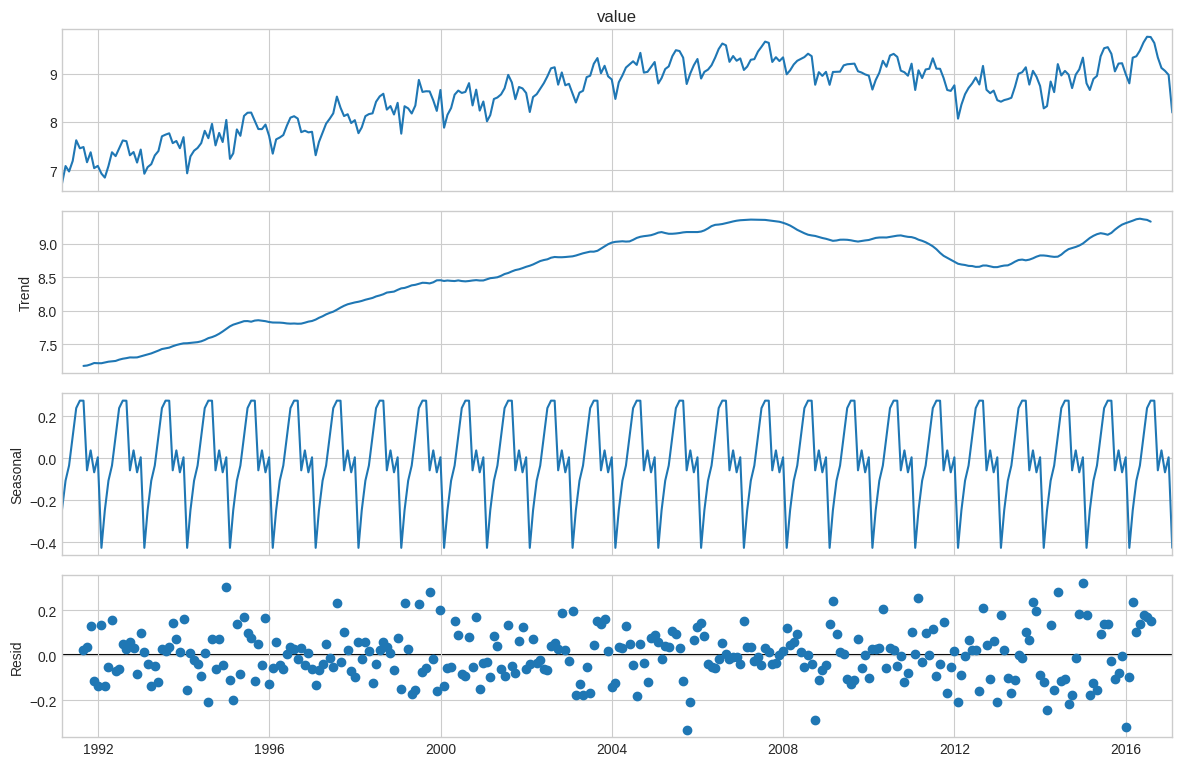

In [53]:
# Ваш код здесь
# 1. Выполните декомпозицию
# Для ежемесячных данных (годовая сезонность) period=12
decomposition = seasonal_decompose(gas_monthly['value'], model='additive', period=12)

# 2. Постройте график
# Визуализация результатов с помощью встроенного метода .plot()
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## Часть 3. Стационарность и корреляционный анализ

**Задание 12. Проверка на стационарность**

Проведите расширенный тест Дики-Фуллера (`adfuller`) для ряда `gas_monthly['value']`. Проанализируйте p-значение и сделайте вывод о стационарности ряда.

In [55]:
# Ваш код здесь
# Выполнение расширенного теста Дики-Фуллера
result = adfuller(gas_monthly['value'])

# Вывод результатов теста
print('Результаты расширенного теста Дики-Фуллера:')
print(f'ADF Статистика: {result[0]}')
print(f'p-значение: {result[1]}')
print(f'Количество использованных лагов: {result[2]}')
print(f'Количество наблюдений: {result[3]}')
print('Критические значения:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Функция для автоматического вывода о стационарности
def adf_test_conclusion(p_value):
    if p_value <= 0.05:
        print("\nВывод: **Нулевая гипотеза отвергается (p-значение < 0.05)**. Ряд, вероятно, является стационарным.")
    else:
        print("\nВывод: **Недостаточно оснований отвергнуть нулевую гипотезу (p-значение > 0.05)**. Ряд, вероятно, является нестационарным.")

adf_test_conclusion(result[1])

Результаты расширенного теста Дики-Фуллера:
ADF Статистика: -2.197750310305149
p-значение: 0.2070629774633031
Количество использованных лагов: 16
Количество наблюдений: 295
Критические значения:
   1%: -3.452713099849546
   5%: -2.871387839457783
   10%: -2.5720171933352485

Вывод: **Недостаточно оснований отвергнуть нулевую гипотезу (p-значение > 0.05)**. Ряд, вероятно, является нестационарным.


**Задание 13. Достижение стационарности через дифференцирование**

Чтобы сделать ряд стационарным, примените к нему дифференцирование первого порядка с помощью метода `.diff()`. Удалите появившееся значение `NaN` и сохраните результат в `gas_monthly_diff`.

Первые 5 значений нового дифференцированного ряда:
date
1991-03-31    0.37100
1991-04-30   -0.11275
1991-05-31    0.21850
1991-06-30    0.42725
1991-07-31   -0.16575
Freq: ME, Name: value, dtype: float64


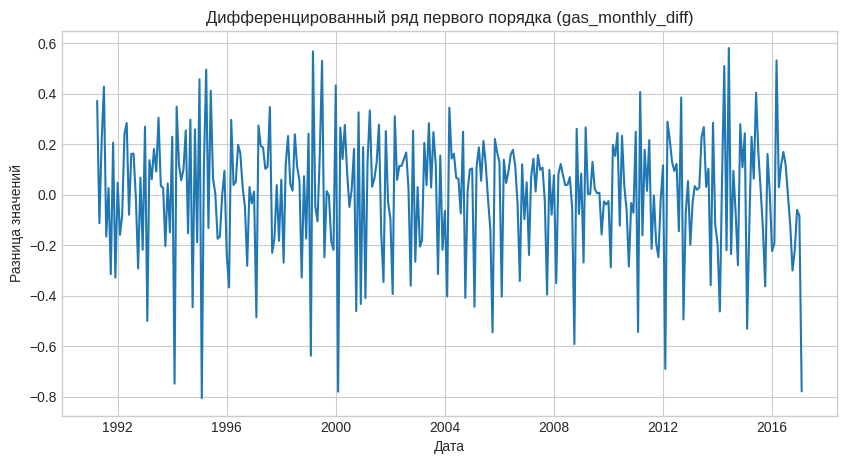

In [56]:
# Ваш код здесь
# 1. Применение дифференцирования первого порядка (.diff())
# Применяем .diff(periods=1) к столбцу 'value'.
# В первой строке появится значение NaN, так как предыдущего значения нет.
gas_monthly_diff = gas_monthly['value'].diff(periods=1)

# 2. Удаление появившегося значения NaN
# Метод .dropna() удаляет строки (или в данном случае единственную строку/элемент Series) с пропущенными значениями.
gas_monthly_diff = gas_monthly_diff.dropna()

# Вывод первых нескольких строк нового ряда, чтобы убедиться, что NaN удален
print("Первые 5 значений нового дифференцированного ряда:")
print(gas_monthly_diff.head())

# (Опционально) График нового ряда, чтобы визуально оценить стационарность
plt.figure(figsize=(10, 5))
plt.plot(gas_monthly_diff.index, gas_monthly_diff.values)
plt.title('Дифференцированный ряд первого порядка (gas_monthly_diff)')
plt.xlabel('Дата')
plt.ylabel('Разница значений')
plt.grid(True)
plt.show()

**Задание 14. Повторная проверка на стационарность**

Проведите тест Дики-Фуллера для нового, дифференцированного ряда `gas_monthly_diff`. Сравните p-значение с предыдущим результатом.

In [61]:
# Ваш код здесь
# Выполнение расширенного теста Дики-Фуллера для дифференцированного ряда
result_diff = adfuller(gas_monthly_diff)

# Вывод результатов теста
print('--- Результаты теста Дики-Фуллера для ДИФФЕРЕНЦИРОВАННОГО ряда (gas_monthly_diff) ---')
print(f'ADF Статистика: {result_diff[0]}')
print(f'p-значение: {result_diff[1]}')
print(f'Количество использованных лагов: {result_diff[2]}')
print(f'Количество наблюдений: {result_diff[3]}')
print('Критические значения:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value}')

# Функция для автоматического вывода о стационарности
def adf_test_conclusion(p_value):
    if p_value <= 0.05:
        print("\nВывод: **Нулевая гипотеза отвергается (p-значение < 0.05)**. Ряд **является стационарным** на уровне значимости 5%.")
    else:
        print("\nВывод: **Недостаточно оснований отвергнуть нулевую гипотезу (p-значение > 0.05)**. Ряд, вероятно, является нестационарным.")

adf_test_conclusion(result_diff[1])

print("\nСравнение p-значений исходного и дифференциированного ряда:")
if result[1] > result_diff[1]:
  print("Oперация дифференцирования первого порядка успешно сделала временной ряд стационарным")
else:
  print("Дифференциирование первого порядка временного ряда не дало положительного результата")

--- Результаты теста Дики-Фуллера для ДИФФЕРЕНЦИРОВАННОГО ряда (gas_monthly_diff) ---
ADF Статистика: -3.063922895836377
p-значение: 0.029340836396295172
Количество использованных лагов: 16
Количество наблюдений: 294
Критические значения:
   1%: -3.452789844280995
   5%: -2.871421512222641
   10%: -2.5720351510944512

Вывод: **Нулевая гипотеза отвергается (p-значение < 0.05)**. Ряд **является стационарным** на уровне значимости 5%.

Сравнение p-значений исходного и дифференциированного ряда:
Oперация дифференцирования первого порядка успешно сделала временной ряд стационарным


**Задание 15. Анализ автокорреляции (ACF)**

Постройте график автокорреляционной функции (ACF) для стационарного ряда `gas_monthly_diff`. Это поможет определить порядок компоненты MA в модели ARIMA.

<Figure size 1000x600 with 0 Axes>

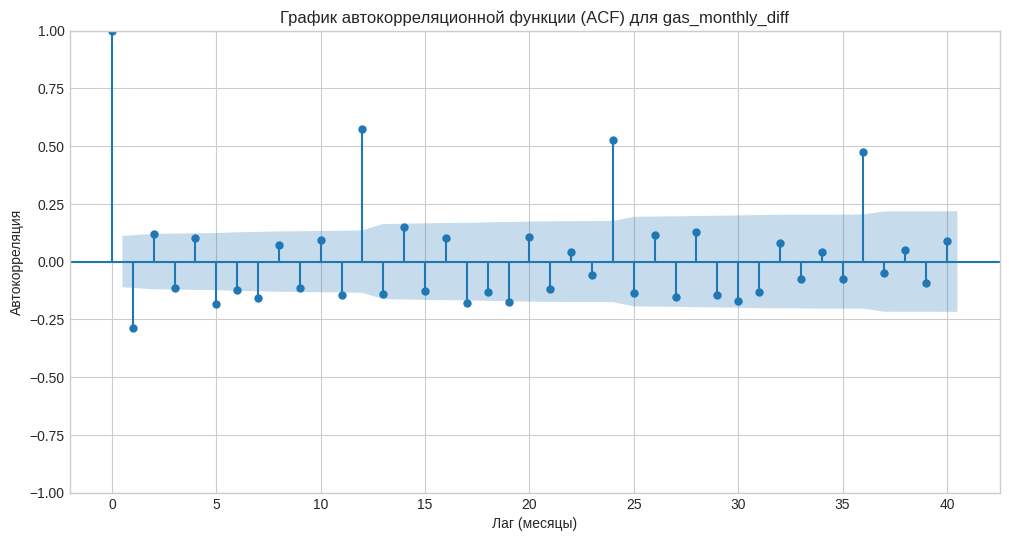

In [62]:
# Ваш код здесь
# Построение графика автокорреляционной функции (ACF)
plt.figure(figsize=(10, 6))

# Параметр 'lags' определяет количество отображаемых лагов (задержек).
# alpha=0.05 добавляет синюю заштрихованную область доверительного интервала (95%).
plot_acf(gas_monthly_diff, lags=40, alpha=0.05)

plt.title('График автокорреляционной функции (ACF) для gas_monthly_diff')
plt.xlabel('Лаг (месяцы)')
plt.ylabel('Автокорреляция')
plt.grid(True)
plt.show()

**Задание 16. Анализ частичной автокорреляции (PACF)**

Постройте график частичной автокорреляционной функции (PACF) для `gas_monthly_diff`. Это поможет определить порядок компоненты AR в модели ARIMA.

<Figure size 1000x600 with 0 Axes>

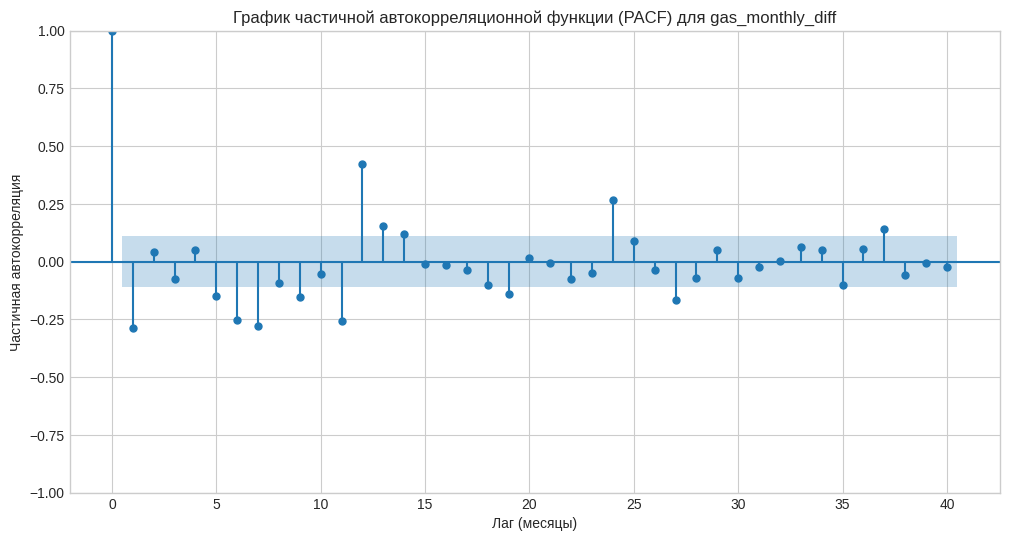

In [63]:
# Ваш код здесь

# Построение графика частичной автокорреляционной функции (PACF)
plt.figure(figsize=(10, 6))

# Параметр 'lags' определяет количество отображаемых лагов (задержек).
# Метод 'ywm' часто работает лучше для коротких или средних рядов.
plot_pacf(gas_monthly_diff, lags=40, alpha=0.05, method='ywm')

plt.title('График частичной автокорреляционной функции (PACF) для gas_monthly_diff')
plt.xlabel('Лаг (месяцы)')
plt.ylabel('Частичная автокорреляция')
plt.grid(True)
plt.show()


## Часть 4. Построение и оценка прогнозной модели ARIMA

Модель ARIMA (AutoRegressive Integrated Moving Average) — одна из самых популярных моделей для прогнозирования временных рядов.

- **AR (p):** Авторегрессионная часть, использующая зависимость от `p` предыдущих значений.
- **I (d):** Интегрированная часть, отвечающая за количество дифференцирований (`d`) для достижения стационарности.
- **MA (q):** Часть скользящего среднего, использующая зависимость от `q` предыдущих ошибок прогноза.

**Задание 17. Разделение данных на обучающую и тестовую выборки**

Разделите `gas_monthly['value']` на обучающую (все данные до 2015 года) и тестовую (данные с 2015 года) выборки. Это позволит нам оценить качество модели на данных, которые она не видела при обучении.

Размер обучающей выборки (до 2015-01-01): 287 наблюдений.
Размер тестовой выборки (с 2015-01-01): 25 наблюдений.


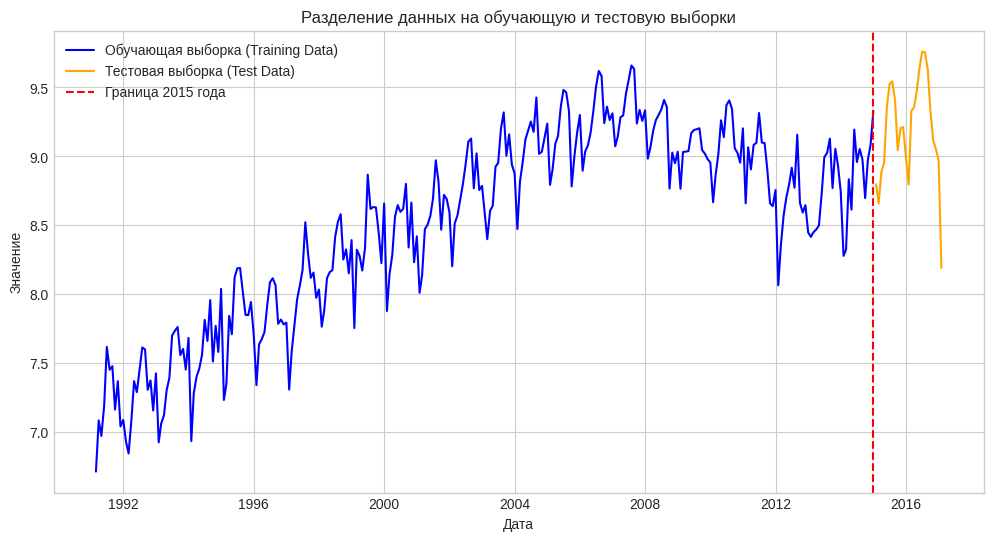

In [65]:
# Ваш код здесь
# 1. Определение даты разделения
split_date = '2015-01-01'

# 2. Разделение на обучающую и тестовую выборки с использованием индексации
# Обучающая выборка: все, что строго до даты начала теста
train_data = gas_monthly[gas_monthly.index < split_date]['value']

# Тестовая выборка: все, что начинается с даты разделения и далее
test = gas_monthly[gas_monthly.index >= split_date]['value']

print(f"Размер обучающей выборки (до {split_date}): {len(train_data)} наблюдений.")
print(f"Размер тестовой выборки (с {split_date}): {len(test)} наблюдений.")

# (Опционально) Визуализация разделения
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Обучающая выборка (Training Data)', color='blue')
plt.plot(test.index, test.values, label='Тестовая выборка (Test Data)', color='orange')
plt.title('Разделение данных на обучающую и тестовую выборки')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.axvline(pd.to_datetime(split_date), color='red', linestyle='--', label='Граница 2015 года')
plt.legend()
plt.grid(True)
plt.show()

**Задание 18. Обучение модели ARIMA**

Обучите модель ARIMA на обучающей выборке (`train_data`). На основе графиков ACF/PACF и того, что мы применили одно дифференцирование, выберем порядок `(p, d, q) = (2, 1, 2)`. Выведите сводку по модели с помощью `.summary()`.

In [66]:
# Ваш код здесь
# Определение порядка модели ARIMA: (p=2, d=1, q=2)
# p=2: Порядок авторегрессии (AR)
# d=1: Порядок интегрирования (дифференцирования)
# q=2: Порядок скользящего среднего (MA)

order = (2, 1, 2)

print(f"Попытка обучения модели ARIMA с порядком {order}...")

try:
    # Инициализация модели
    model = ARIMA(train_data, order=order)

    # Обучение (подгонка) модели
    model_fit = model.fit()

    # Вывод сводной информации по модели
    print("\n--- Сводка по модели ARIMA (2, 1, 2) ---")
    print(model_fit.summary())
    print("------------------------------------------")

except Exception as e:
    print(f"\nПроизошла ошибка при обучении модели: {e}")
    print("Возможно, выбранный порядок (2, 1, 2) не подходит для ваших данных или данные слишком короткие.")

Попытка обучения модели ARIMA с порядком (2, 1, 2)...


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'



--- Сводка по модели ARIMA (2, 1, 2) ---
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  287
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  38.541
Date:                Sun, 07 Dec 2025   AIC                            -67.083
Time:                        21:42:42   BIC                            -48.803
Sample:                    02-28-1991   HQIC                           -59.756
                         - 12-31-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4038      0.086     -4.695      0.000      -0.572      -0.235
ar.L2          0.5961      0.086      6.952      0.000       0.428       0.764
ma.L1     

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Задание 19. Построение прогноза**

Сделайте прогноз на период, соответствующий тестовой выборке. Используйте `model_fit.predict()`, указав `start` и `end` индексы тестовой выборки.

In [69]:
# Ваш код здесь
# Определение начального и конечного индекса для прогноза
# Используем индексы (даты) из тестовой выборки
start_index = test.index[0]      # Первая дата тестовой выборки
end_index = test.index[-1]       # Последняя дата тестовой выборки

print(f"Начало прогноза: {start_index}")
print(f"Конец прогноза: {end_index}")

# Выполнение прогнозирования с помощью метода .predict() 'dynamic=False' означает, что для каждого последующего прогноза
# используются фактические предыдущие значения из обучающей выборки, а не ранее спрогнозированные значения (прогноз на один шаг вперед).
predictions = model_fit.predict(start=start_index, end=end_index, dynamic=False)

# Сохранение результатов прогноза в новый объект Series для удобства анализа
predictions.name = 'Прогноз ARIMA (2,1,2)'

# Вывод первых нескольких значений прогноза
print("\nПервые 5 значений прогноза:")
print(predictions.head())


Начало прогноза: 2015-01-31 00:00:00
Конец прогноза: 2017-01-31 00:00:00

Первые 5 значений прогноза:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
Freq: ME, Name: Прогноз ARIMA (2,1,2), dtype: float64


**Задание 20. Визуализация прогноза**

Постройте график, на котором будут отображены обучающие данные, реальные тестовые данные и ваш прогноз.

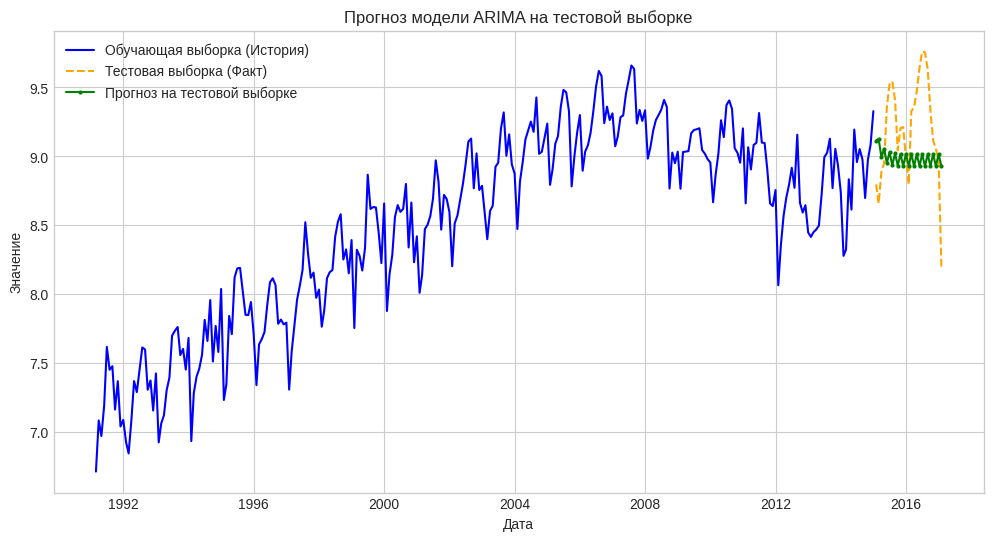

In [70]:
# Ваш код здесь

# Добавьте линию для прогноза
#Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Обучающая выборка (История)', color='blue')
plt.plot(test.index, test.values, label='Тестовая выборка (Факт)', color='orange', linestyle='--')
plt.plot(predictions.index, predictions.values, label='Прогноз на тестовой выборке', color='green', linestyle='-', marker='o', markersize=2)
plt.title('Прогноз модели ARIMA на тестовой выборке')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

**Задание 21. Оценка качества модели**

Рассчитайте метрику RMSE (Root Mean Squared Error) для оценки точности вашего прогноза. RMSE = `sqrt(mean_squared_error(y_true, y_pred))`.

In [76]:
# Ваш код здесь
import math
# Убедитесь, что оба ряда имеют одинаковую длину и выровнены по индексу
if len(test) == len(predictions):
    # Рассчитываем MSE (Mean Squared Error)
    mse = mean_squared_error(test, predictions)

    # Рассчитываем RMSE (Root Mean Squared Error)
    rmse = math.sqrt(mse)

    print(f"\n--- Оценка точности прогноза ---")
    print(f"Количество сравнений (длина теста): {len(test)}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("--------------------------------")

    # (Опционально) Рассчитать среднее значение ряда для контекста
    mean_value = test.mean()
    print(f"Среднее значение тестовой выборки: {mean_value:.4f}")

    # Сравнение RMSE со средним значением ряда помогает понять масштаб ошибки.
else:
    print("Ошибка: Длины тестовой выборки и прогноза не совпадают. Проверьте предыдущие шаги.")
    print(f"Длина test: {len(test)}, Длина predictions: {len(predictions)}")



--- Оценка точности прогноза ---
Количество сравнений (длина теста): 25
Mean Squared Error (MSE): 0.1900
Root Mean Squared Error (RMSE): 0.4359
--------------------------------
Среднее значение тестовой выборки: 9.1995


**Задание 22. Прогноз на будущее**

Теперь, когда модель оценена, используйте ее для прогнозирования на 12 месяцев вперед (за пределы имеющихся данных). Используйте метод `.forecast()`.

In [77]:
# Ваш код здесь
# 1. Выполнение прогноза на следующие 12 шагов (месяцев)
# Метод .forecast() автоматически определяет, откуда начинать прогноз (сразу после последней даты, использованной в обучении/предыдущем прогнозе).
steps_ahead = 12
forecast_results = model_fit.forecast(steps=steps_ahead)

print(f"\nПрогноз на следующие {steps_ahead} месяцев:")
print(forecast_results)



Прогноз на следующие 12 месяцев:
2015-01-31    9.115067
2015-02-28    9.127644
2015-03-31    8.995342
2015-04-30    9.056262
2015-05-31    8.952799
2015-06-30    9.030891
2015-07-31    8.937685
2015-08-31    9.021871
2015-09-30    8.932318
2015-10-31    9.018661
2015-11-30    8.930415
2015-12-31    9.017516
Freq: ME, Name: predicted_mean, dtype: float64


**Задание 23. Визуализация прогноза на будущее**

Постройте график, включающий все исторические данные (`gas_monthly['value']`) и прогноз на будущее.

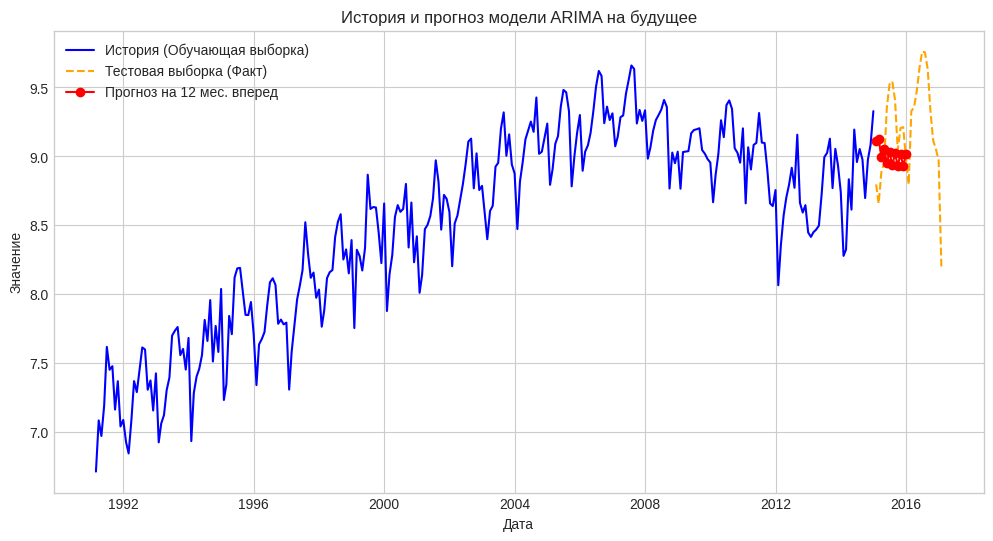

In [78]:
# Ваш код здесь
#Визуализация всего ряда и будущего прогноза
plt.figure(figsize=(12, 6))

# История (обучающая выборка)
plt.plot(train_data.index, train_data.values, label='История (Обучающая выборка)', color='blue')

# Факт (тестовая выборка):
plt.plot(test.index, test.values, label='Тестовая выборка (Факт)', color='orange', linestyle='--')

# Прогноз за пределами данных
plt.plot(forecast_results.index, forecast_results.values, label=f'Прогноз на {steps_ahead} мес. вперед', color='red', linestyle='-', marker='o')

plt.title('История и прогноз модели ARIMA на будущее')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


## Часть 5. Индивидуальные задания для самостоятельной работы

**Инструкция.** Выполните задания, соответствующие вашему варианту. В качестве основного набора данных используйте `gas_monthly` (ежемесячные данные о производстве бензина) или `unemployment_df` (квартальные данные об уровне безработицы), как указано в задании. Сначала загрузим второй датасет.

In [36]:
unemployment_url = "https://raw.githubusercontent.com/BosenkoTM/Python_for_scientists/refs/heads/main/data/US_unemployment.csv"
unemployment_df = pd.read_csv(unemployment_url, parse_dates=['date'], index_col='date')
print("Данные по безработице (head):")
print(unemployment_df.head())

print("\nДанные по производству бензина (head):")
print(gas_monthly.head())

Данные по безработице (head):
            value
date             
1959-03-31    5.8
1959-06-30    5.1
1959-09-30    5.3
1959-12-31    5.6
1960-03-31    5.2

Данные по производству бензина (head):
              value
date               
1991-02-28  6.71500
1991-03-31  7.08600
1991-04-30  6.97325
1991-05-31  7.19175
1991-06-30  7.61900


---
**Вариант 1:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2005 по 2010 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 6 месяцев.
4. **Стационарность:** Примените дифференцирование первого порядка и проведите тест Дики-Фуллера.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2014 года и сделайте прогноз на 12 шагов вперед.

---
**Вариант 2:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график всего временного ряда уровня безработицы.
3. **Декомпозиция:** Разложите ряд на тренд, сезонность и остаток.
4. **Корреляция:** Постройте график ACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,0) на данных до 2010 года и сделайте прогноз на 8 кварталов вперед.

---
**Вариант 3:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 1995 по 2000 год.
3. **Преобразование:** Рассчитайте и нанесите на график скользящее среднее с окном 24 месяца.
4. **Стационарность:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,1) на данных до 2013 года и сделайте прогноз на 12 шагов.

---
**Вариант 4:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2000 года до конца.
3. **Стационарность:** Примените дифференцирование и проверьте на стационарность с помощью теста ADF.
4. **Корреляция:** Постройте график PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(1,1,1) на данных до 2012 года, сделайте и визуализируйте прогноз на тестовом периоде (оставшиеся данные).

---
**Вариант 5:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию ряда `gas_monthly`.
3. **Преобразование:** Агрегируйте данные до квартальной частоты (`'Q'`), используя медиану.
4. **Стационарность:** Проверьте агрегированный ряд на стационарность.
5. **Прогноз:** Обучите модель ARIMA(1,1,0) на `gas_monthly` (данные до 2012) и сделайте прогноз на 6 шагов.

---
**Вариант 6:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1990 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите модель ARIMA(2,1,2) на данных до 2005 года и сделайте прогноз на 10 кварталов.

---
**Вариант 7:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за последние 5 лет (с 2012 года).
3. **Стационарность:** Примените дифференцирование второго порядка (`.diff().diff()`) и проверьте на стационарность.
4. **Корреляция:** Постройте ACF для ряда после двойного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,2,1) на данных до 2015 года и оцените её RMSE на оставшихся данных.

---
**Вариант 8:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 8 кварталов (2 года).
4. **Стационарность:** Проведите тест ADF для исходного и дифференцированного рядов, сравните результаты.
5. **Прогноз:** Обучите модель ARIMA(0,1,1) на данных до 2008 года и сделайте прогноз на 12 кварталов.

---
**Вариант 9:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему значению.
3. **Декомпозиция:** Разложите исходный ежемесячный ряд на компоненты.
4. **Корреляция:** Постройте PACF для исходного ряда.
5. **Прогноз:** Обучите модель ARIMA(3,1,0) на данных до 2011 года и сделайте прогноз на 18 месяцев.

---
**Вариант 10:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1970 по 1985 год.
3. **Преобразование:** Примените логарифмическое преобразование (`np.log`) к ряду и постройте его график.
4. **Стационарность:** Проверьте на стационарность логарифмированный ряд после одного дифференцирования.
5. **Прогноз:** Обучите модель ARIMA(1,1,2) на данных до 2000 года и сделайте прогноз на 15 кварталов.

---
**Вариант 11:**
1. **Данные:** `gas_monthly`
2. **EDA:** Рассчитайте и постройте график годового скользящего среднего (окно 12).
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите модель ARIMA(1,1,1). Выведите `.summary()`.
5. **Оценка:** Разделите данные на train/test по 2013 году. Рассчитайте RMSE прогноза на тестовой выборке.

---
**Вариант 12:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию. Проанализируйте график сезонной компоненты.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Корреляция:** Постройте ACF для остатков.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2007 года и спрогнозируйте на 10 кварталов.

---
**Вариант 13:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2010 года до конца.
3. **Преобразование:** Агрегируйте данные до 6-месячной частоты (`'6M'`) по сумме.
4. **Стационарность:** Проверьте стационарность агрегированного ряда.
5. **Прогноз:** Обучите ARIMA(0,1,2) на `gas_monthly` (данные до 2010) и сделайте прогноз на 24 месяца.

---
**Вариант 14:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график дифференцированного ряда.
3. **Корреляция:** Постройте PACF для дифференцированного ряда. Определите возможный порядок `p`.
4. **Моделирование:** Обучите модель ARIMA с порядком `p`, определённым на шаге 3, и `d=1`, `q=1`.
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед от конца имеющихся данных.

---
**Вариант 15:**
1. **Данные:** `gas_monthly`
2. **EDA:** Проведите декомпозицию. Выведите первые 5 значений трендовой и сезонной компонент.
3. **Преобразование:** Рассчитайте процентное изменение от месяца к месяцу (`.pct_change()`) и постройте график.
4. **Стационарность:** Проверьте на стационарность ряд процентных изменений.
5. **Прогноз:** Обучите ARIMA(2,1,2) на данных до 2011 года и сделайте прогноз на 12 шагов.

---
**Вариант 16:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 2 (полгода).
3. **Корреляция:** Постройте ACF для дифференцированного ряда. Определите возможный порядок `q`.
4. **Моделирование:** Обучите модель ARIMA с порядком `q`, определённым на шаге 3, и `d=1`, `p=1`.
5. **Оценка:** Разделите данные по 2009 году. Рассчитайте RMSE модели на тестовой выборке.

---
**Вариант 17:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за период с 2008 по 2012 год.
3. **Декомпозиция:** Проведите декомпозицию и постройте график только для сезонной компоненты.
4. **Стационарность:** Проведите тест ADF на сезонной компоненте.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2010 года, спрогнозируйте на 12 шагов.

---
**Вариант 18:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1995 по 2005 год.
3. **Преобразование:** Рассчитайте скользящее стандартное отклонение (`.rolling(4).std()`).
4. **Корреляция:** Постройте ACF и PACF для исходного (недифференцированного) ряда.
5. **Прогноз:** Обучите ARIMA(3,1,1) на данных до 2011 года, сделайте прогноз на 8 кварталов.

---
**Вариант 19:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до годовой частоты по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,2) на данных до 2014 года.
5. **Прогноз:** Сделайте и визуализируйте прогноз на оставшихся данных (тестовый период).

---
**Вариант 20:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график исходных данных и наложите на него скользящее среднее с окном 10.
3. **Стационарность:** Проведите ADF тест на остатках (residuals) после декомпозиции.
4. **Моделирование:** Обучите модель ARIMA(2,1,3) на данных до 2006 года.
5. **Прогноз:** Сделайте прогноз на 12 кварталов вперед.

---
**Вариант 21:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте данные за 2000-2004 гг.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 18 месяцев.
4. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,0) на данных до 2013 года, спрогнозируйте на 15 месяцев.

---
**Вариант 22:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Стационарность:** Проведите тест ADF на трендовой компоненте.
4. **Моделирование:** Обучите модель ARIMA(0,1,2) на данных до 2011 года.
5. **Оценка:** Сделайте прогноз на тестовом периоде (остальные данные) и рассчитайте RMSE.

---
**Вариант 23:**
1. **Данные:** `gas_monthly`
2. **EDA:** Агрегируйте данные до квартальной частоты (`'Q'`) по максимальному значению и постройте график.
3. **Корреляция:** Постройте ACF для этого агрегированного ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на агрегированном ряде (до 2014 года).
5. **Прогноз:** Сделайте прогноз на 4 квартала вперед.

---
**Вариант 24:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1985 по 1995 год.
3. **Преобразование:** Рассчитайте скользящую медиану с окном 3 (`.rolling(3).median()`).
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,1) на данных до 2004 года и сделайте прогноз на 8 кварталов.

---
**Вариант 25:**
1. **Данные:** `gas_monthly`
2. **EDA:** Визуализируйте остатки (residuals) после декомпозиции.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите модель ARIMA(3,1,2) на данных до 2012 года.
5. **Прогноз:** Сделайте прогноз на 10 месяцев вперед.

---
**Вариант 26:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных, агрегированных до годовой частоты (`'A'`) по среднему.
3. **Корреляция:** Постройте ACF для годового ряда.
4. **Моделирование:** Обучите ARIMA(1,1,0) на годовом ряде (до 2010 года).
5. **Прогноз:** Сделайте прогноз на 5 лет вперед.

---
**Вариант 27:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график скользящего среднего с окном 3 месяца.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,0) на данных до 2013 года.
5. **Оценка:** Рассчитайте RMSE модели на тестовом периоде (данные с 2013 года).

---
**Вариант 28:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 2005 года до конца.
3. **Декомпозиция:** Проведите декомпозицию и постройте график трендовой компоненты.
4. **Стационарность:** Проведите тест ADF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(1,1,3) на данных до 2009 года и сделайте прогноз на 8 кварталов.

---
**Вариант 29:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график данных за первые 10 лет (до 2001 года).
3. **Преобразование:** Рассчитайте логарифм ряда и примените к нему дифференцирование.
4. **Корреляция:** Постройте PACF для этого преобразованного ряда.
5. **Прогноз:** Обучите ARIMA(2,1,2) на исходных данных до 2010 года и сделайте прогноз на 12 шагов.

---
**Вариант 30:**
1. **Данные:** `unemployment_df`
2. **EDA:** Проведите декомпозицию ряда.
3. **Корреляция:** Постройте ACF и PACF для дифференцированного ряда.
4. **Моделирование:** Обучите ARIMA(2,1,2) на данных до 2012 года.
5. **Прогноз:** Визуализируйте прогноз на тестовом периоде и рассчитайте RMSE.

---
**Вариант 31:**
1. **Данные:** `gas_monthly`
2. **EDA:** Постройте график ряда, агрегированного до квартальной частоты по медиане.
3. **Стационарность:** Проведите тест ADF для этого квартального ряда.
4. **Моделирование:** Обучите ARIMA(1,1,1) на квартальном ряде (до 2012 года).
5. **Прогноз:** Сделайте прогноз на 6 кварталов вперед.

---
**Вариант 32:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график скользящего среднего с окном 5.
3. **Корреляция:** Постройте ACF для ряда, дифференцированного дважды.
4. **Моделирование:** Обучите ARIMA(1,2,1) на данных до 2007 года.
5. **Прогноз:** Сделайте прогноз на 10 кварталов.

---
**Вариант 33:**
1. **Данные:** `gas_monthly`
2. **EDA:** Декомпозируйте ряд. Постройте график остатков.
3. **Стационарность:** Проведите тест ADF на остатках.
4. **Моделирование:** Обучите ARIMA(2,1,3) на данных до 2015 года.
5. **Прогноз:** Сделайте прогноз на 12 месяцев вперед.

---
**Вариант 34:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных с 1999 по 2009 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном 6.
4. **Корреляция:** Постройте PACF для дифференцированного ряда.
5. **Прогноз:** Обучите ARIMA(3,1,0) на данных до 2010 года и спрогнозируйте на 8 кварталов.

---
**Вариант 35:**
1. **Данные:** `unemployment_df`
2. **EDA:** Постройте график данных за период с 1980 по 2000 год.
3. **Преобразование:** Рассчитайте скользящее среднее с окном в 4 квартала (1 год).
4. **Корреляция:** Постройте ACF и PACF для ряда, дифференцированного дважды (`.diff().diff()`).
5. **Прогноз:** Обучите модель ARIMA(2,2,2) на данных до 2008 года и спрогнозируйте следующие 10 кварталов.


Вариант 2
Результат выполнения Задания 2:


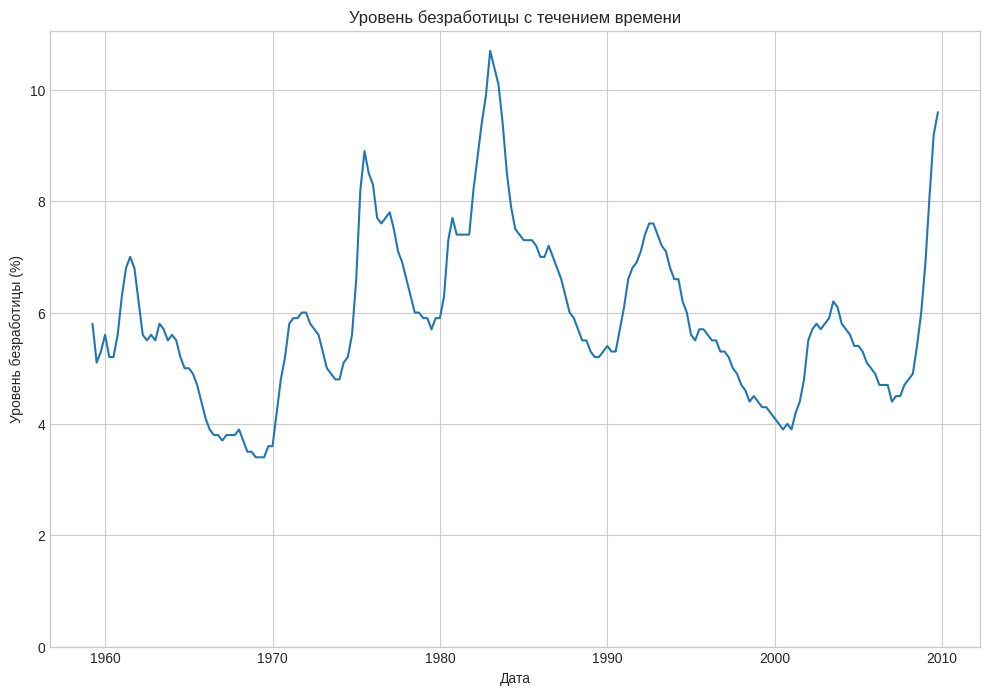

--------------------------------------------------------------------------------------------------------------------------------------------
Результат выполнения Задания 3:


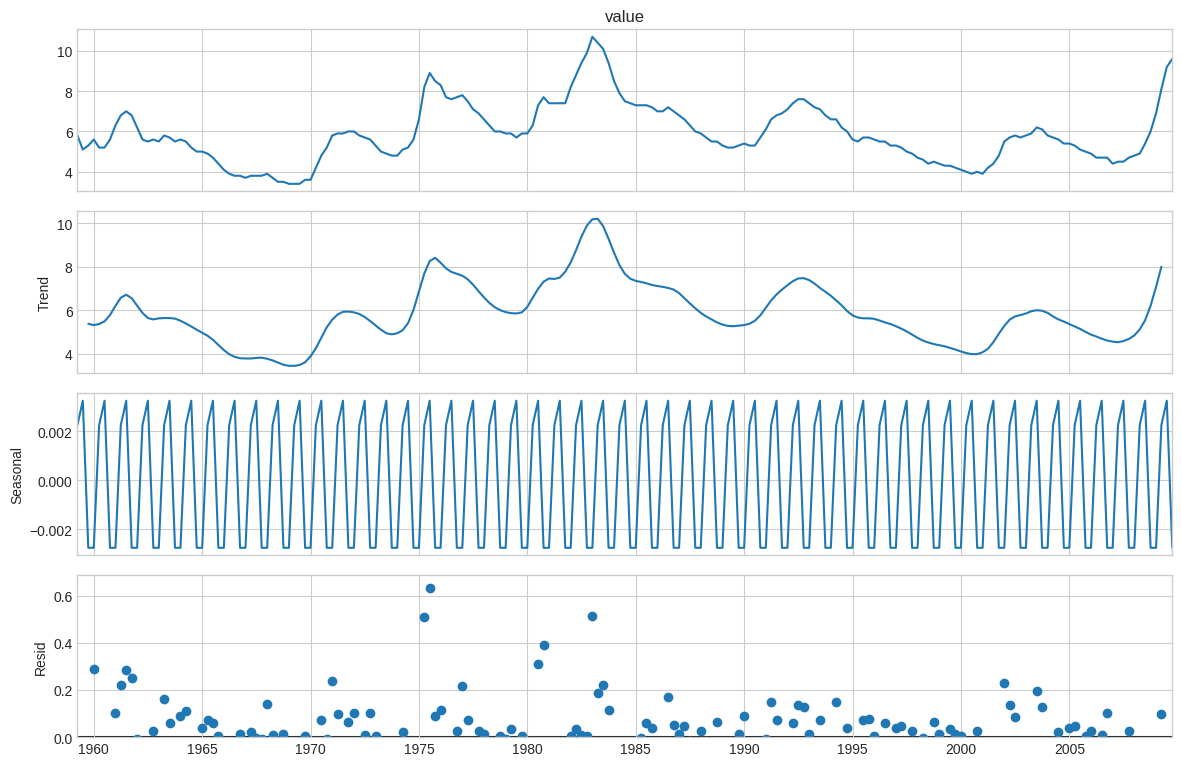

--------------------------------------------------------------------------------------------------------------------------------------------
Результат выполнения Задания 4:


<Figure size 1000x500 with 0 Axes>

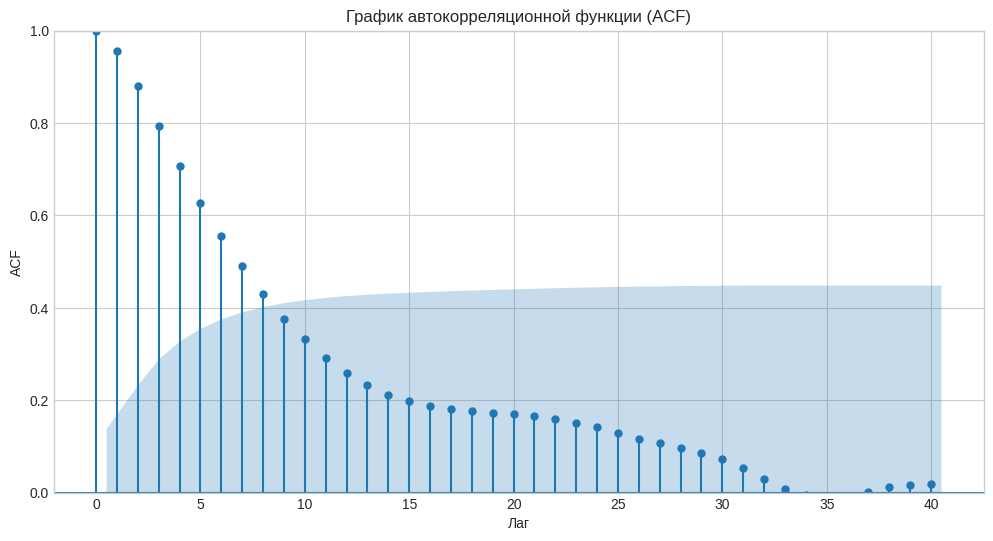

--------------------------------------------------------------------------------------------------------------------------------------------
Результат выполнения Задания 5:
Прогноз на 8 кварталов вперед:


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


,predicted_mean
2009-12-31,9.759316
2010-03-31,9.827572
2010-06-30,9.858334
2010-09-30,9.872645
2010-12-31,9.879427
2011-03-31,9.882676
2011-06-30,9.884240
2011-09-30,9.884996


In [46]:
# Варианта 2
print('Вариант 2')
#Задание 2:
print('Результат выполнения Задания 2:')

#1. Построение графика
# Устанавливаем размер графика для лучшей читаемости
plt.figure(figsize=(12, 8))
plt.plot(unemployment_df.index, unemployment_df['value'])
# 2. Добавление заголовка и подписей осей
plt.title('Уровень безработицы с течением времени')
plt.xlabel('Дата')
plt.ylabel('Уровень безработицы (%)')
# Устанавливаем минимальное значение оси Y равным 0
plt.ylim(ymin=0)
plt.grid(True)

plt.show()

print('-'*140)

#Задание 3:
print('Результат выполнения Задания 3:')

# Импортируем функцию seasonal_decompose из модуля statsmodels.tsa.seasonal
from statsmodels.tsa.seasonal import seasonal_decompose

# Выполняем сезонную декомпозицию временного ряда 'value' из DataFrame unemployment_df.
# Используется аддитивная модель ('additive'), которая предполагает, что исходный ряд является суммой тренда, сезонности и остатка.
decomposition = seasonal_decompose(unemployment_df['value'], model='additive')

# Создаем объект графика (figure) из результата декомпозиции. Этот график автоматически отображает все четыре компонента ряда.
fig = decomposition.plot()
fig.set_size_inches(12, 8)
# Устанавливаем минимальное значение оси Y равным 0
plt.ylim(ymin=0)

plt.show()

print('-'*140)

#Задание 4:
print('Результат выполнения Задания 4:')

plt.figure(figsize=(10, 5))

# Строим график автокорреляционной функции (ACF) для столбца 'value' из DataFrame unemployment_df.
# Параметр lags=40 указывает количество лагов (сдвигов по времени), которые нужно отобразить на графике.
plot_acf(unemployment_df['value'], lags=40)

plt.xlabel('Лаг')
plt.ylabel('ACF')
plt.title('График автокорреляционной функции (ACF)')
plt.grid(True)
# Устанавливаем минимальное значение оси Y равным 0
plt.ylim(ymin=0)

plt.show()

print('-'*140)

#Задание 5:
print('Результат выполнения Задания 5:')

from statsmodels.tsa.arima.model import ARIMA
import datetime

# Разделение данных: обучающая выборка до 2010 года
train_data = unemployment_df[unemployment_df.index < datetime.datetime(2010, 1, 1)]

# Обучение модели ARIMA(2, 1, 0)
model = ARIMA(train_data['value'], order=(2, 1, 0))
model_fit = model.fit()

# Прогноз на 8 кварталов вперед
forecast_steps = 8
forecast = model_fit.forecast(steps=forecast_steps)

print("Прогноз на 8 кварталов вперед:")
display(forecast)